# Dataset Overview
Saya menggunakan dataset dari kaggle berikut ini https://www.kaggle.com/omkargurav/face-mask-dataset

## Konten
Dataset berisi 7553 gambar (RGB) yang terdiri dari 3725 `with_mask` dan 3828 `without_mask`.

In [3]:
!pip install tensorflow==2.1.0
!pip install opencv-python==4.2.0.34
!pip install pandas==1.2.0
!pip instsall numpy==1.18.1

     |████████████████████████████████| 421.8MB 31kB/s 
     |████████████████████████████████| 3.9MB 48.9MB/s 
     |████████████████████████████████| 450kB 59.5MB/s 
     |████████████████████████████████| 51kB 9.3MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=aa24b7b6873f7e6ebf70d95ab6c5bb9a2f7c80e78ed352dd438537817ab4f50a
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.4.0
    Uninstalling tensorboard-2.4.0:
      Successfully uninstalled tensorboard-2.4.0
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tens

     |████████████████████████████████| 28.2MB 119kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: Could not find a version that satisfies the requirement pandas==1.2.0 (from versions: 0.1, 0.2b0, 0.2b1, 0.2, 0.3.0b0, 0.3.0b2, 0.3.0, 0.4.0, 0.4.1, 0.4.2, 0.4.3, 0.5.0, 0.6.0, 0.6.1, 0.7.0rc1, 0.7.0, 0.7.1, 0.7.2, 0.7.3, 0.8.0rc1, 0.8.0rc2, 0.8.0, 0.8.1, 0.9.0, 0.9.1, 0.10.0, 0.10.1, 0.11.0, 0.12.0, 0.13.0, 0.13.1, 0.14.0, 0.14.1, 0.15.0, 0.15.1, 0.15.2, 0.16.0, 0.16.1, 0.16.2, 0.17.0, 0.17.1, 0.18.0, 0.18.1, 0.19.0rc1, 0.19.0, 0.19.1, 0.19.2, 0.20.0rc1, 0.20.0, 0.20.1, 0.20.2, 0.20.3, 0.21.0rc1, 0.21.0, 0.21.1, 0.22.0, 0.23.0rc2, 0.23.0, 0.23.1, 0.23.2, 0.23.3, 0.23.4, 0.24.0rc1, 0.24.0, 0.24.1, 0.24.2, 0.25.0rc0, 0.25.0, 0.25.1, 0.25.2, 0.25.3, 1.0.0rc0, 1.0

In [1]:
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
keras = tf.keras

In [2]:
tf.__version__

'2.1.0'

In [3]:
os.chdir('drive/My Drive/PythonProject/Face Mask Detection')

In [4]:
!tree -d

/bin/bash: tree: command not found


## Loading Data

In [5]:
# Inisialiasi data generator beserta dengan menerapkan image augmentation
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

Karena gambar kita memilki ukuran yang berbeda beda maka kita resize
setiap gambar menjadi 150x150 dengan parameter target_size

In [6]:
# Flow from directory untuk memuat gambar
train_generator = train_datagen.flow_from_directory(
    'dataset/train/',
    target_size=(224,224),
    batch_size=32,
    class_mode='binary'
)

Found 6043 images belonging to 2 classes.


In [7]:
valid_generator = train_datagen.flow_from_directory(
    'dataset/valid/',
    target_size=(224,224),
    batch_size=32,
    class_mode='binary'
)

Found 1510 images belonging to 2 classes.


## Loading Dataset

In [8]:
def loading_data():
    dirname = 'dataset/'
    dirtype = ['train/','valid/']
    dirclass = ['with_mask/','without_mask/']
    
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    
    for typ in dirtype:
        for cls in dirclass:
            for i in os.listdir(dirname+typ+cls):
                if typ == 'train/':
                    x_train.append(dirname+'train/'+cls+i)
                    y_train.append(cls[:-1])
                else:
                    x_test.append(dirname+'valid/'+cls+i)
                    y_test.append(cls[:-1])
    return np.array(x_train),np.array(y_train),np.array(x_test),np.array(y_test)

In [9]:
x_train,y_train,x_test,y_test = loading_data()

In [10]:
x_train,x_test

(array(['dataset/train/with_mask/with_mask_3267.jpg',
        'dataset/train/with_mask/with_mask_3268.jpg',
        'dataset/train/with_mask/with_mask_3269.jpg', ...,
        'dataset/train/without_mask/without_mask_1269.jpg',
        'dataset/train/without_mask/without_mask_127.jpg',
        'dataset/train/without_mask/without_mask_1270.jpg'], dtype='<U48'),
 array(['dataset/valid/with_mask/with_mask_585.jpg',
        'dataset/valid/with_mask/with_mask_586.jpg',
        'dataset/valid/with_mask/with_mask_587.jpg', ...,
        'dataset/valid/without_mask/without_mask_442.jpg',
        'dataset/valid/without_mask/without_mask_443.jpg',
        'dataset/valid/without_mask/without_mask_444.jpg'], dtype='<U48'))

In [11]:
y_train,y_test

(array(['with_mask', 'with_mask', 'with_mask', ..., 'without_mask',
        'without_mask', 'without_mask'], dtype='<U12'),
 array(['with_mask', 'with_mask', 'with_mask', ..., 'without_mask',
        'without_mask', 'without_mask'], dtype='<U12'))

## Data Preprocessing

In [12]:
unique_label = np.unique(y_test)

In [13]:
unique_label

array(['with_mask', 'without_mask'], dtype='<U12')

In [14]:
def process_label(label):
    label = [i == unique_label for i in label]
    label = np.array(label).astype(int)
    return label

In [15]:
def processImage(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image,channels=3)
    image = tf.image.convert_image_dtype(image,tf.float32)
    image = tf.image.resize(image,size=[224,224])
    return image

In [16]:
y_test = process_label(y_test)
y_train = process_label(y_train)

## Batch Data

In [17]:
def pairData(image,label):
    return processImage(image),label

In [18]:
def batchData(image,label=None,for_valid=False,for_test=False):
    if for_test:
        data = tf.data.Dataset.from_tensor_slices((image))
        batch = data.map(processImage).batch(32)
        return batch
    elif for_valid:
        data = tf.data.Dataset.from_tensor_slices((tf.constant(image),tf.constant(label)))
        batch = data.map(pairData).batch(32)
        return batch
    else:
        data = tf.data.Dataset.from_tensor_slices((tf.constant(image),tf.constant(label)))
        data = data.shuffle(buffer_size=len(image))
        batch = data.map(pairData).batch(32)
        return batch

In [19]:
train_data = batchData(x_train,y_train)
valid_data = batchData(x_test,y_test,for_valid=True)

In [20]:
train_data,valid_data

(<BatchDataset shapes: ((None, 224, 224, 3), (None, 2)), types: (tf.float32, tf.int64)>,
 <BatchDataset shapes: ((None, 224, 224, 3), (None, 2)), types: (tf.float32, tf.int64)>)

# Visualisasi Data

In [21]:
def visualizeNextBatch(image,label):
    plt.figure(figsize=(20,10))
    for i in range(32):
        ax = plt.subplot(4,8,i+1)
        plt.imshow(image[i])
        plt.title(unique_label[label[i].argmax()])
        plt.axis('off')

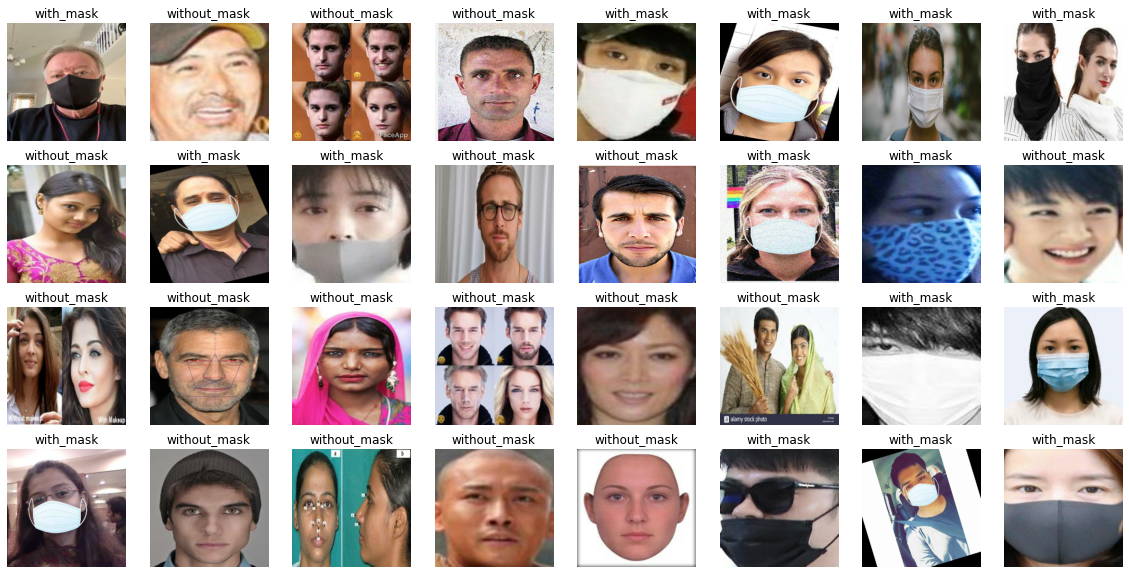

In [23]:
train_image,train_label = next(train_data.as_numpy_iterator())
visualizeNextBatch(train_image,train_label)

# Membangun Neural Network

In [24]:
model = keras.Sequential([
    # Input Layer
    keras.layers.Conv2D(input_shape=(224,224,3),filters=32,kernel_size=(3,3),activation='relu'),
    keras.layers.MaxPooling2D(),
    
    # Hidden Layer
    keras.layers.Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(input_shape=(224,224,3),filters=128,kernel_size=(3,3),activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(128),
    keras.layers.Activation('relu'),
    
    # Output Layer
    keras.layers.Dense(2),
    keras.layers.Activation('softmax')
])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 86528)             0

In [26]:
model.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.Adam(),metrics=['acc'])

## Early Stopping

In [27]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)

## Training NN Model

In [28]:
history = model.fit(train_data,validation_data = valid_data,validation_freq=1,epochs = 50,callbacks = [early_stopping],verbose = 1,)

Train for 189 steps, validate for 48 steps
Epoch 1/50
  6/189 [..............................] - ETA: 39:19 - loss: 1.6064 - acc: 0.4500WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc


KeyboardInterrupt: ignored

In [ ]:
model.save('output/face_mask_ai_2.1.0.h5')

## Plot Proses Training

In [ ]:
def plot_history():
    plt.plot(history.history['acc'],label='acc')
    plt.plot(history.history['val_acc'],label='val_acc')
    plt.plot(history.history['loss'],label='loss')
    plt.plot(history.history['val_loss'],label='val_loss')
    plt.legend()
    plt.title('Training History')
    plt.xlabel('epoch')
    plt.ylabel('value')
    plt.tight_layout()
    plt.grid(True)
    plt.savefig('output/training_history.jpg')
    plt.show()

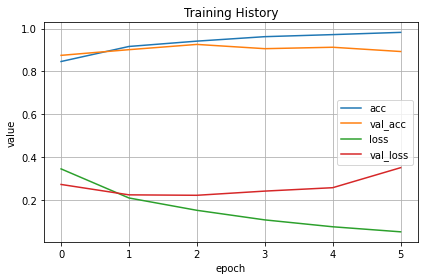

In [ ]:
plot_history()

# Demonstrasi Prediksi

In [ ]:
def predict(unseen_image = []):
    test_data = batchData(unseen_image,for_test=True)
    prediction = model.predict(test_data)

    for image,pred in zip(unseen_image,prediction):
        fig,axes = plt.subplots(nrows=1,ncols=2)
        axes[0].imshow(processImage(image))
        axes[0].axis(False)
        axes[0].set_title('Actual Image')

        axes[1].bar([0,1],pred)
        axes[1].set_xticks([0,1])
        axes[1].set_xticklabels(['with_mask','without_mask'])
        axes[1].set_title('Prediction Probability')
        plt.savefig(f'output/prediction_test_{image.split("/")[-1].split(".")[0]}.jpg')
        plt.show()

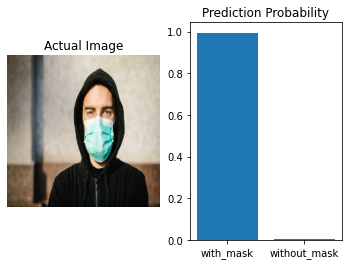

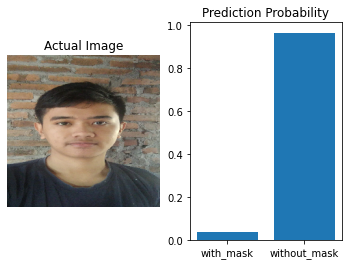

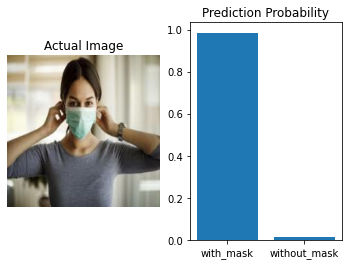

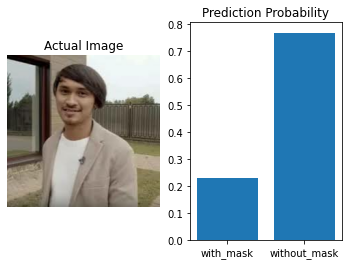

In [ ]:
predict(list(map(lambda x : f'test/{x}', os.listdir('test'))))